# Imports:

In [2]:
import os

import librosa
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
from scipy.io import wavfile
import scipy.stats as stats
import re

# Extract frequency features:

## Get metadata:

In [ ]:
current_path = os.getcwd()
source = os.path.join(current_path, "CommonVoice")

metadata = pd.read_csv(source + "/train.csv", delimiter='	')
data = metadata[['path','gender']]
data_male = data.loc[data['gender'] == 'male']
data_male = data_male.sample(frac=1).reset_index(drop=True)
data_male = data_male[:263]
data_female = data.loc[data['gender'] == 'female']

data = pd.concat([data_male,data_female])
data= data.sample(frac=1).reset_index(drop=True)
data['path'] = data['path'].str.replace('.mp3','.wav')

data_dict = dict(zip(data.path, data.gender))

## Example:

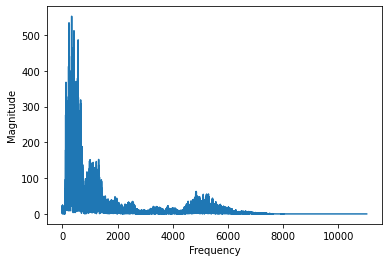

In [47]:
current_path = os.getcwd()
file_path = os.path.join(current_path,"CommonVoice", "Full", "common_voice_pt_19275113.wav")
audio_data, sample_rate = librosa.load(file_path)
step = int(sample_rate/5)
window_frequencies = []
top_freq = []

ft = np.fft.fft(audio_data)
magnitude = np.abs(ft)
frequency = np.linspace(0, sample_rate, len(magnitude))

plt.figure()
plt.plot(frequency[:int(len(frequency)/2)], magnitude[:int(len(frequency)/2)])
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

## Extract features:

In [61]:
def get_frequencies(files):
    frequencies_list = []
    gender_list = []
    FileName_list = []
    print("Extracting frequencies...")
    keys = data_dict.keys()
    for k, file in enumerate(files):
        if file.endswith('.wav') and file in keys:
            file_path = os.path.join(current_path,"MLS", "Full", file)
            if data_dict[file] == 'female':
                gender = 0
            if data_dict[file] == 'male': 
                gender = 1
            audio_data, sample_rate = librosa.load(file_path)

            step = int(sample_rate/15) #3200 sampling points every 1/5 sec
            window_frequencies = []

            for i in range(0,len(audio_data),step):
                ft = np.fft.fft(audio_data[i:i+step]) #fft returns the list N complex numbers
                freqs = np.fft.fftfreq(len(ft)) #fftq tells you the frequencies associated with the coefficients
                imax = np.argmax(np.abs(ft))
                freq = freqs[imax]
                freq_in_hz = abs(freq *sample_rate)
                window_frequencies.append(freq_in_hz)
            FileName_list.append(file)
            gender_list.append(gender)
            frequencies_list.append(window_frequencies)
            print(f"\r{k/len(files)*100:.3f}% complete",end='')
    return frequencies_list, gender_list, FileName_list

In [62]:
def get_features(frequencies):

  nobs, minmax, mean, variance, skew, kurtosis =  stats.describe(frequencies)
  median   = np.median(frequencies)
  mode     = stats.mode(frequencies).mode[0]
  std      = np.std(frequencies)
  low,peak = minmax
  q75,q25  = np.percentile(frequencies, [75 ,25])
  iqr      = q75 - q25
  return nobs, mean, skew, kurtosis, median, mode, std, low, peak, q25, q75, iqr

In [63]:
current_path = os.getcwd()
file_path = os.path.join(current_path,"CommonVoice", "Full")
audio_files = os.listdir(file_path)
frequencies, gender_list, FileName_list = get_frequencies(audio_files)
features_list = []
for i, frequency in enumerate(frequencies):
    nobs, mean, skew, kurtosis, median, mode, std, low, peak, q25, q75, iqr = get_features(frequency)
    features_list.append([FileName_list[i], nobs, mean, skew, kurtosis, median, mode, std, low, peak, q25, q75, iqr, gender_list[i]])
df = pd.DataFrame(features_list, columns = ['FileName', 'nobs', 'mean', 'skew', 'kurtosis', 'median', 'mode', 'std', 'low', 'peak', 'q25', 'q75', 'iqr', 'Gender'])
df.to_csv('data/Commonvoice_Features_data.csv', index=False)

Extracting frequencies...


/home/brunohonorio/tcc/Speaker-Gender-Recognition/venv/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: [Errno 2] No such file or directory: '/home/brunohonorio/tcc/Speaker-Gender-Recognition/MLS/Full/common_voice_pt_20431674.wav'